# Rubik's Cube Solver

## Dependencies

In [1]:
import cv2
import imutils
import pathlib
import numpy as np
from imutils import perspective
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (6, 6)

## Loading a sample

In [10]:
def load_image(
    path: pathlib.Path, eq: bool = False, verbose: bool = False
) -> np.ndarray:
    img = cv2.imread(path)
    img = imutils.resize(img, width=240)
    if eq:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        img[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
        img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if verbose:
        plt.figure()
        plt.imshow(img)
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(hsv)
        plt.figure()
        plt.subplot(131)
        plt.imshow(h)
        plt.subplot(132)
        plt.imshow(s)
        plt.subplot(133)
        plt.imshow(v)
        plt.tight_layout()
    return img

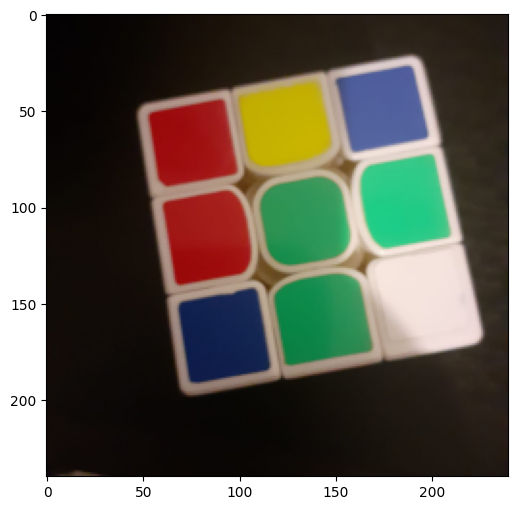

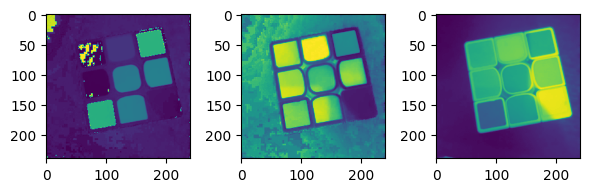

In [76]:
sample = load_image("data/1.png", eq=False, verbose=True)

In [77]:
def threshold_channel(channel):
    blurred = cv2.GaussianBlur(channel, (5, 5), 0)
    adaptive = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 4
    )
    return adaptive
    _, binarized = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    res = cv2.subtract(binarized, adaptive)

    plt.figure()
    plt.subplot(141)
    plt.title("binarized")
    plt.imshow(binarized)
    plt.subplot(142)
    plt.title("adaptive")
    plt.imshow(adaptive)
    plt.subplot(143)
    plt.title("res")
    plt.imshow(res)

    # morph = cv2.morphologyEx(
    #     res, cv2.MORPH_OPEN, np.ones((7, 7), np.uint8), iterations=4
    # )
    morph = cv2.morphologyEx(
        res, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=6
    )

    plt.subplot(144)
    plt.title("morphology")
    plt.imshow(morph)

    return adaptive

In [78]:
def get_square(binarized: np.ndarray):
    edges = imutils.auto_canny(binarized, sigma=0.1)
    cnts = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

    max_peri = -np.inf
    biggest = None
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.04 * peri, True)
        if len(approx) == 4:
            if peri > max_peri:
                max_peri = peri
                biggest = approx
    return max_peri, biggest

In [79]:
def get_best_channel(a: np.ndarray, b: np.ndarray):
    a_bin = threshold_channel(a)
    b_bin = threshold_channel(b)

    a_peri, a_cnts = get_square(a_bin)
    b_peri, b_cnts = get_square(b_bin)

    if a_cnts is None and b_cnts is None:
        raise Exception("Both are bad!")
    elif a_cnts is not None and b_cnts is not None:
        if a_peri > b_peri:
            return a_cnts
        else:
            return b_cnts
    elif a_cnts is not None:
        return a_cnts
    else:
        return b_cnts

In [80]:
def fix_perspective(rgb_img: np.ndarray, verbose: bool = False):
    hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
    s = hsv_img[:, :, 1]
    v = hsv_img[:, :, 2]

    cnts = get_best_channel(s, v)

    rect = cv2.minAreaRect(cnts)
    box = cv2.boxPoints(rect)
    pts_src = np.array(box, dtype=np.float32)
    origin_x, origin_y = box[0]
    width = rgb_img.shape[0]
    height = rgb_img.shape[1]
    pts_dst = np.array(
        [
            [0, 0],
            [width, 0],
            [width, height],
            [0, height],
        ],
        dtype=np.float32,
    )
    M, _ = cv2.findHomography(pts_src, pts_dst)
    fixed = cv2.warpPerspective(rgb_img, M, (width, height))

    if verbose:
        plt.figure()
        rgb_cnts = rgb_img.copy()
        # overlay box
        cv2.drawContours(rgb_cnts, cnts, -1, (0, 255, 0), 1)
        cv2.drawContours(rgb_cnts, [box.astype(np.int32)], -1, (0, 0, 255), 2)

        plt.subplot(121)
        plt.imshow(rgb_cnts)
        plt.subplot(122)
        plt.imshow(fixed)
        plt.tight_layout()

    corrected = perspective.four_point_transform(rgb_img, box)
    return corrected

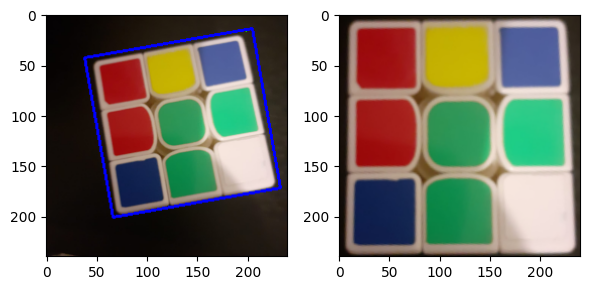

In [82]:
warped = fix_perspective(sample, verbose=True)

In [89]:
def segment_colors(rgb_img: np.ndarray, boost: bool = False, verbose: bool = False):
    flattened = warped.reshape((-1, 3))
    flattened = np.float32(flattened)
    iters = 16
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, iters, 0.1)
    _, labels, centers = cv2.kmeans(
        flattened, 6, None, criteria, iters, cv2.KMEANS_PP_CENTERS
    )
    centers = np.uint8(centers)
    labels = labels.flatten()
    flattened = centers[labels]
    segmented = flattened.reshape(warped.shape)
    if boost:
        segmented = cv2.convertScaleAbs(segmented, alpha=1.2, beta=0)

    if verbose:
        plt.figure()
        plt.imshow(segmented)

    return segmented

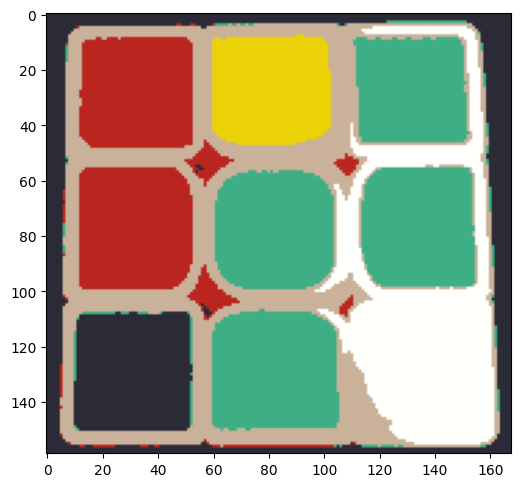

In [90]:
segmented = segment_colors(warped, boost=True, verbose=True)

In [91]:
def get_cells(segmented: np.ndarray, w_size: int = 10) -> list[np.ndarray]:
    height, width, _ = segmented.shape
    cell_width = width // 3
    cell_height = height // 3
    cells = []
    for y in range(3):
        for x in range(3):
            x_min = x * cell_width + w_size
            x_max = x_min + w_size
            y_min = y * cell_height + w_size
            y_max = y_min + w_size
            cell = segmented[y_min:y_max, x_min:x_max]
            cells.append(cell)
    return cells

In [92]:
COLORS = {
    "blue": [(0,0,104), (0,255,0), (151,151,255)],
    "green": [(0, 104, 0), (0, 255, 0), (151, 202, 151)],
    "orange": [(104, 68, 0), (255, 165, 0), (255, 218, 151)],
    "red": [(104, 0, 0), (255, 0, 0), (255, 151, 151)],
    "white": [(204, 204, 204), (255, 255, 255), (255, 255, 255)],
    "yellow": [(104, 104, 0), (255, 255, 0), (255, 255, 151)],
}

COLORS = {name: np.array(color) for name, color in COLORS.items()}

In [93]:
def distance(a: np.ndarray, b: np.ndarray) -> float:
    return np.sqrt(np.sum((a - b) ** 2))

In [94]:
def color_distance(color: np.ndarray, reference, margin: int = 50) -> float:
    d_low = distance(color, np.clip(reference - margin, 0, 255))
    d_base = distance(color, reference)
    d_upper = distance(color, np.clip(reference + margin, 0, 255))
    return 3000 / (d_low + d_base + d_upper)

In [95]:
def classify_color(piece: np.ndarray, colors: dict) -> (str, float):
    scores = {}
    for name, (lower, base, upper) in colors.items():
        score_lower = color_distance(piece, lower)
        score_base = color_distance(piece, base)
        score_upper = color_distance(piece, upper)
        scores[name] = 0.2 * score_lower + 0.5 * score_base + 0.3 * score_upper
    best_color = max(scores, key=scores.get)
    return best_color, scores[best_color]

In [96]:
def get_face(
    rgb_image: np.ndarray, w_size: int = 10, verbose: bool = False
) -> np.ndarray:
    warped = fix_perspective(rgb_image, verbose=verbose)
    segmented = segment_colors(warped, boost=True, verbose=verbose)
    cells = get_cells(segmented, w_size=w_size)
    face = [classify_color(cell, COLORS) for cell in cells]
    colors = np.array([color for (color, _) in face]).reshape((3, 3))
    if verbose:
        scores = np.array([score for (_, score) in face]).reshape((3, 3))
        plt.figure()
        for y in range(3):
            for x in range(3):
                cell = cells[y * 3 + x]
                color = colors[y, x]
                score = scores[y, x]
                plt.subplot(3, 3, y * 3 + x + 1)
                plt.imshow(cell)
                plt.title(f"{color}: {score:.2f}")
                plt.axis("off")
        plt.tight_layout()
    return colors

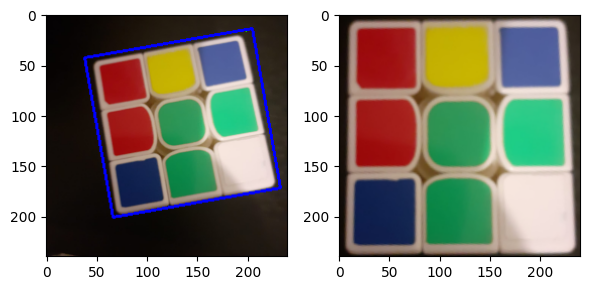

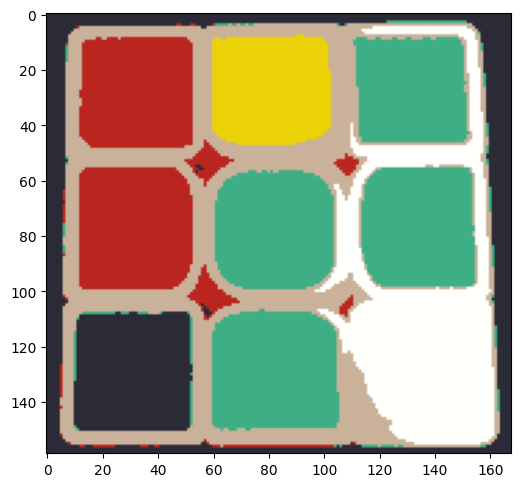

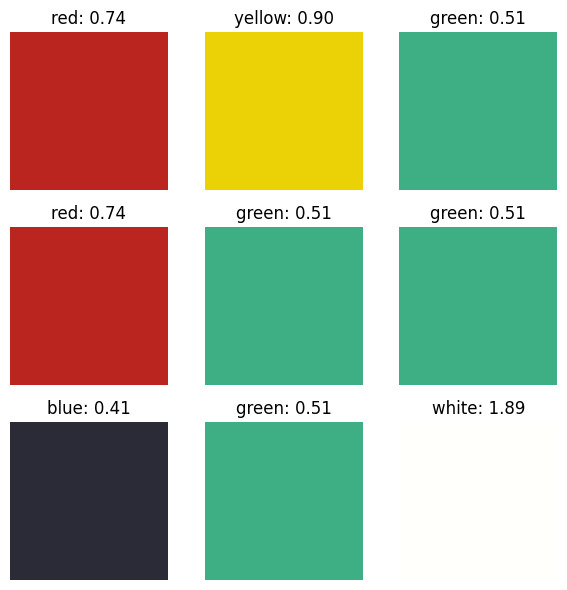

In [97]:
cube = get_face(sample, w_size=15, verbose=True)